# Project 3
### Moiya Josephs


## Ask

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

## The Data Set

The names corpus is a collection of female and male names. As explained in the Chapter 6 of Natural Language Processing with Python textbook, female names often end in a, e or i and male names often end in k, o, r, s and t. Classifier models can be used to predict what bucket a name can fall in.

In [1]:
from nltk.corpus import names
import random

In [65]:
import nltk
import pandas as pd
from collections import Counter


In [3]:
nltk.download('names')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


True

### Combine the Male and Female Names

Combining both names from the datasets and labeling them to be either male or female. But first I will remove names that occur in both lists.

In [33]:
labeled_names = ([(name, 'male') for name in names.words('male.txt')] +
                 [(name, 'female') for name in names.words('female.txt')])
labeled_names = list(set(labeled_names))
random.shuffle(labeled_names)

The length of names in the male names dataset is shown below. The length of the names are slighly skewed and most names seem to be of length 6.

#### Length of Male or Female names

In [36]:
male_list = list(filter(lambda x:'male' in x, labeled_names))
female_list = list(filter(lambda x:'female' in x, labeled_names))

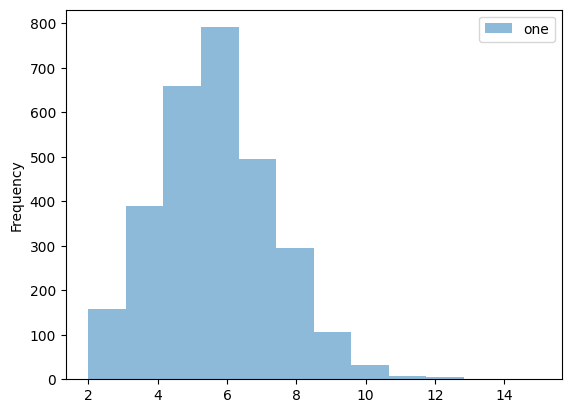

In [42]:
male_len = []
for name in male_list:
  male_len.append(len(name[0]))

df = pd.DataFrame(male_len, columns=['one'])
ax = df.plot.hist(bins=12, alpha=0.5)


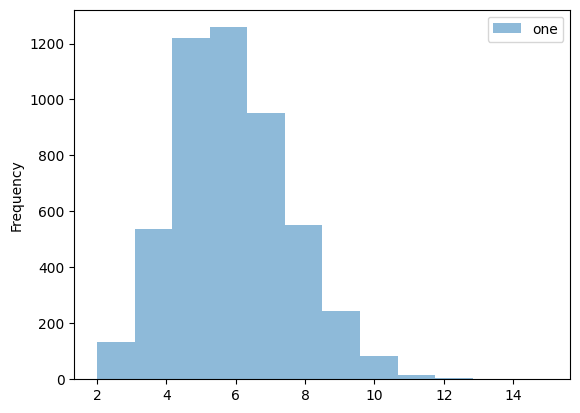

In [44]:
female_len = []
for name in female_list:
  female_len.append(len(name[0]))

df = pd.DataFrame(female_len, columns=['one'])
ax = df.plot.hist(bins=12, alpha=0.5)

The distribution of the names lengths are similar but there are more names with 4 letters in the female text than the male. This feature may help descern the difference between a male or female name.

#### Suffix

According to the textbook, most male words end in "k", "o", "r", "s" and "t". According to the distirbution of the names text, this is shown to be not true at least for the given dataset. Even though this is opposite to the text, the opposite seems to be true so there is some correlation in the suffix.

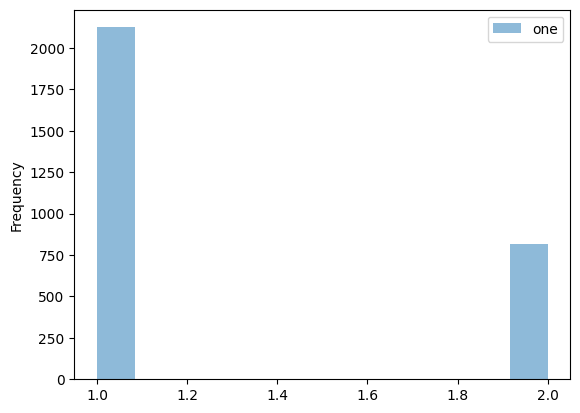

In [45]:
male_len = []
for name in male_list:
  if name[0][-1] in ("k", "o", "r", "s" , "t"):
    male_len.append(2)
  else:
    male_len.append(1)

df = pd.DataFrame(male_len, columns=['one'])
ax = df.plot.hist(bins=12, alpha=0.5)

According to the textbook, the female names end in "a", "e" and "i". In this dataset, this shows to be true.

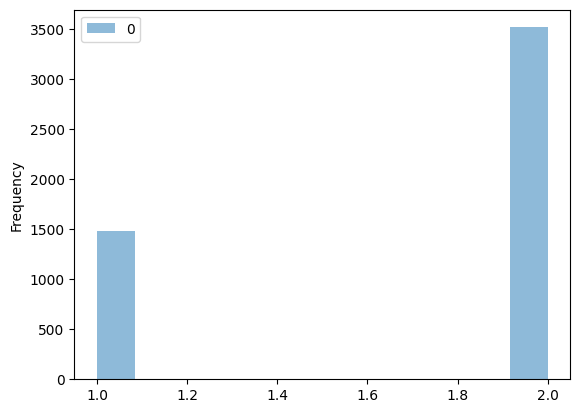

In [58]:
female_len = []
for name in female_list:
  if name[0][-1] in ("a", "e", "i"):
    female_len.append(2)
  else:
    female_len.append(1)

df = pd.DataFrame(female_len)
ax = df.plot.hist(bins=12, alpha=0.5)

To investigate this further, I will subset the last letter for each male and female name and see if there is a clear trend that I can utilize.

In [68]:
female_suffix = []
for name in female_list:
  female_suffix.append(name[0][-1])


<Axes: >

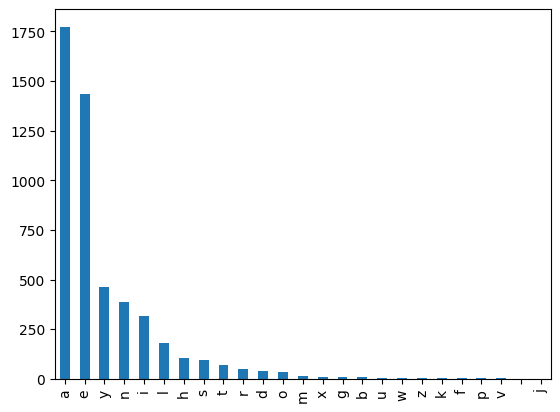

In [67]:
counts = Counter(female_suffix)
df_ver = pd.DataFrame.from_dict(counts, orient='index')
df_ver =  df_ver.sort_values(0, ascending = False)
df_ver.plot(kind = "bar", legend = False)

In [69]:
male_suffix = []
for name in male_list:
  male_suffix.append(name[0][-1])

<Axes: >

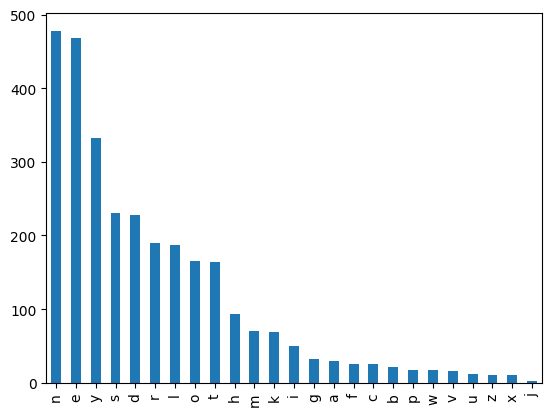

In [70]:
counts = Counter(male_suffix)
df_ver = pd.DataFrame.from_dict(counts, orient='index')
df_ver =  df_ver.sort_values(0, ascending = False)
df_ver.plot(kind = "bar", legend = False)

From evaluating the last letter for male and female names. The most common letter suffix in the male list is n, e, y, s and d.

For female, it is a,e, y, n and i.

There are two common letter suffixes (n, y, e and a).

In [74]:
"weekness"[-2:]

'ss'

<Axes: >

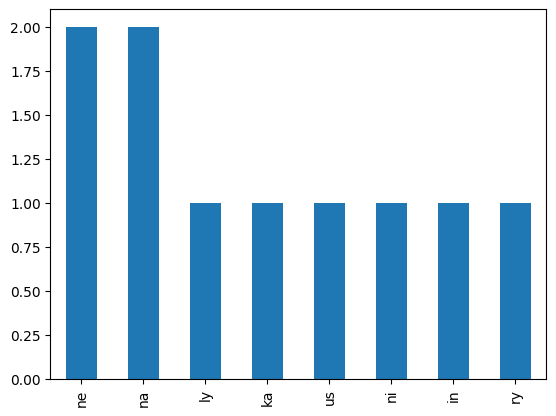

In [83]:
female_suffix = []
for name in female_list:
  female_suffix.append(name[0][-2:])

counts = Counter(female_suffix[:10])
df_ver = pd.DataFrame.from_dict(counts, orient='index')
df_ver =  df_ver.sort_values(0, ascending = False)
df_ver.plot(kind = "bar", legend = False)

<Axes: >

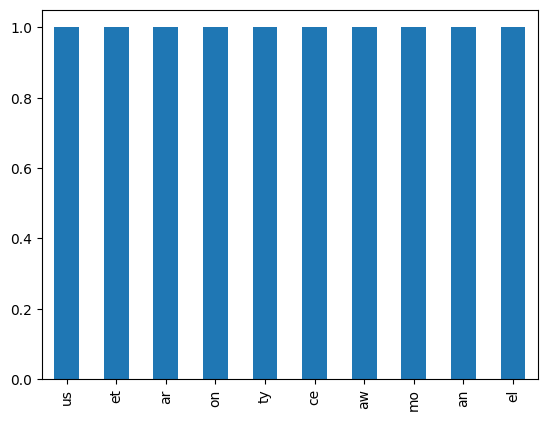

In [86]:
male_suffix = []
for name in male_list:
  male_suffix.append(name[0][-2:])

counts = Counter(male_suffix[:10])
df_ver = pd.DataFrame.from_dict(counts, orient='index')
df_ver =  df_ver.sort_values(0, ascending = False)
df_ver.plot(kind = "bar", legend = False)

The last two letters for female and male list do not appear to have any commonalitys, and this may be an optimal feature to use in the classifiers.

## Model Training

Splitting the labeled names by the training, devtest and test set. The training set is used to train the model and devtest is used to check against errors. At first I will train the dataset based on the last letter of the word.

In [87]:
def gender_features(word):
  return {'suffix1': word[-1:], 'suffix2': word[-2:]}

In [88]:
train_names = labeled_names[1500:]
devtest_names = labeled_names[500:1500]
test_names = labeled_names[:500]

In [89]:
train_set = [(gender_features(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features(n), gender) for (n, gender) in test_names]

## Naives Classifier

In [90]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.768


Using just the last letter and the Naive Bayes Classifier, I can see the accuracy is 76.8%. To check the errors, we can use the dev-test set, and generate a list of the errors that the classifier makes when predicting name genders to see what was missed.




In [91]:
errors = []
for (name, tag) in devtest_names:
  guess = classifier.classify(gender_features(name))
  if guess != tag:
    errors.append( (tag, guess, name) )
for (tag, guess, name) in sorted(errors)[:10]:
  print('correct={:<8} guess={:<8s} name={:<30}'.format(tag, guess, name))

correct=female   guess=male     name=Abigael                       
correct=female   guess=male     name=Adel                          
correct=female   guess=male     name=Adelind                       
correct=female   guess=male     name=Adrian                        
correct=female   guess=male     name=Adrien                        
correct=female   guess=male     name=Aeriel                        
correct=female   guess=male     name=Agnes                         
correct=female   guess=male     name=Aileen                        
correct=female   guess=male     name=Alison                        
correct=female   guess=male     name=Allis                         


Errors in from the data set occur when with the first two letters of the name and the last two letters of the name.

I will create a genders features function to include the last letter and the last two letters of the words. Additionally, I will consider the first two letters of a word.


In [96]:
def gender_features1(word):
  return {'first_letter': word[:2].lower(), 'suffix1': word[-1:], 'suffix2': word[-2:]}

train_set = [(gender_features1(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features1(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features1(n), gender) for (n, gender) in test_names]

classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.786


With these new features considered the accuracy is now 78.6%. Next, I will include the length of the names, working under the assumption that there is a correlation and difference between the length of female names compared to the length of male names.

In [94]:
errors = []
for (name, tag) in devtest_names:
  guess = classifier.classify(gender_features1(name))
  if guess != tag:
    errors.append( (tag, guess, name) )
for (tag, guess, name) in sorted(errors)[:10]:
  print('correct={:<8} guess={:<8s} name={:<30}'.format(tag, guess, name))

correct=female   guess=male     name=Abigael                       
correct=female   guess=male     name=Adel                          
correct=female   guess=male     name=Adelind                       
correct=female   guess=male     name=Adrian                        
correct=female   guess=male     name=Adrien                        
correct=female   guess=male     name=Aeriel                        
correct=female   guess=male     name=Agnes                         
correct=female   guess=male     name=Alison                        
correct=female   guess=male     name=Allis                         
correct=female   guess=male     name=Allison                       


In [114]:
def gender_features2(word):
  return {'first_letter': word[:2].lower(), 'suffix2': word[-2:], 'length': len(word)}

train_set = [(gender_features2(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features2(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features2(n), gender) for (n, gender) in test_names]

classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.802


In [105]:
errors = []
for (name, tag) in devtest_names:
  guess = classifier.classify(gender_features2(name))
  if guess != tag:
    errors.append( (tag, guess, name) )

for (tag, guess, name) in sorted(errors)[:10]:
  print('correct={:<8} guess={:<8s} name={:<30}'.format(tag, guess, name))

correct=female   guess=male     name=Abigael                       
correct=female   guess=male     name=Adel                          
correct=female   guess=male     name=Adelind                       
correct=female   guess=male     name=Adrian                        
correct=female   guess=male     name=Agnes                         
correct=female   guess=male     name=Alison                        
correct=female   guess=male     name=Allison                       
correct=female   guess=male     name=Arabel                        
correct=female   guess=male     name=Babs                          
correct=female   guess=male     name=Bert                          


Considering the length of the name along with the other criterias increases the accuracy barely. This makes sense since the two names dataframe do not have significant difference in the lengths.

The most informative features show that the suffix is the most informatice. In this example, the suffix 'na' shows to be 87.5 times more often in female names than in male. Also names ending in "rd" happen 29 times more often than in females.

In [106]:
classifier.show_most_informative_features(10)


Most Informative Features
                 suffix2 = 'na'           female : male   =     90.1 : 1.0
                 suffix2 = 'la'           female : male   =     67.4 : 1.0
                 suffix2 = 'rt'             male : female =     46.1 : 1.0
                 suffix2 = 'ta'           female : male   =     39.7 : 1.0
                 suffix2 = 'us'             male : female =     36.3 : 1.0
                 suffix2 = 'ia'           female : male   =     34.5 : 1.0
                 suffix2 = 'sa'           female : male   =     31.8 : 1.0
                 suffix2 = 'io'             male : female =     26.1 : 1.0
                 suffix2 = 'ra'           female : male   =     23.4 : 1.0
                 suffix2 = 'do'             male : female =     22.8 : 1.0


The next `gender_features` function will consider the first two and the last two letters in the male and female names. Additionally, I will consider the frequency of constonants and vowels.

In [116]:
def gender_features3(word):
  features = {}
  features["first_letter"] = word[:2].lower()
  features["suffix2"] = word[-2:].lower()
  features["length"] = len(word)
  for letter in 'aeiou':
    features["count({})".format(letter)] = word.lower().count(letter)
  for letter in 'bcdfghjklmnpqrstvwxyz':
    features["count({})".format(letter)] = word.lower().count(letter)

  return features

In [109]:
train_set = [(gender_features3(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features3(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features3(n), gender) for (n, gender) in test_names]

classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.806


In [110]:
classifier.show_most_informative_features(10)


Most Informative Features
                 suffix2 = 'na'           female : male   =     90.0 : 1.0
                 suffix2 = 'la'           female : male   =     67.7 : 1.0
                 suffix2 = 'rt'             male : female =     46.2 : 1.0
                 suffix2 = 'ta'           female : male   =     39.7 : 1.0
                 suffix2 = 'us'             male : female =     36.4 : 1.0
                 suffix2 = 'ia'           female : male   =     34.5 : 1.0
                 suffix2 = 'sa'           female : male   =     31.8 : 1.0
                 suffix2 = 'io'             male : female =     26.1 : 1.0
                 suffix2 = 'ra'           female : male   =     23.4 : 1.0
                 suffix2 = 'do'             male : female =     22.8 : 1.0


This method has a slight improvment in accuracy and shows the best accuracy I am able to achieve with a Naive Bayes Classifier is 80.5%.

### Maxent Classifier

Maxent is memory hungry, slower, and it requires numpy. The Max Entropy classifier is a probabilistic classifier which belongs to the class of exponential models. It does not assume that the features are conditionally independent of each other.

Using the same gender features functions that I created earlier, I will test against the Maxent Classifier.

In [134]:
from nltk import MaxentClassifier


train_set = [(gender_features(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features(n), gender) for (n, gender) in test_names]

classifier = MaxentClassifier.train(train_set, max_iter=25)
print(nltk.classify.accuracy(classifier, devtest_set))

  ==> Training (25 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.370
             2          -0.36620        0.812
             3          -0.32192        0.826
             4          -0.30331        0.829
             5          -0.29278        0.833
             6          -0.28583        0.834
             7          -0.28080        0.835
             8          -0.27696        0.838
             9          -0.27391        0.839
            10          -0.27142        0.840
            11          -0.26935        0.840
            12          -0.26760        0.840
            13          -0.26610        0.841
            14          -0.26480        0.841
            15          -0.26367        0.842
            16          -0.26266        0.841
            17          -0.26177        0.841
            18          -0.26098        0.842
            19          -0.26026        0.842
  

In [135]:
train_set = [(gender_features1(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features1(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features1(n), gender) for (n, gender) in test_names]

classifier = MaxentClassifier.train(train_set, max_iter=25)
print(nltk.classify.accuracy(classifier, devtest_set))

  ==> Training (25 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.370
             2          -0.59631        0.630
             3          -0.57084        0.631
             4          -0.54777        0.655
             5          -0.52697        0.694
             6          -0.50825        0.724
             7          -0.49140        0.747
             8          -0.47623        0.765
             9          -0.46254        0.779
            10          -0.45017        0.791
            11          -0.43895        0.799
            12          -0.42876        0.806
            13          -0.41947        0.811
            14          -0.41098        0.815
            15          -0.40319        0.819
            16          -0.39604        0.822
            17          -0.38945        0.824
            18          -0.38336        0.826
            19          -0.37772        0.828
  

In [136]:
train_set = [(gender_features2(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features2(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features2(n), gender) for (n, gender) in test_names]

classifier = MaxentClassifier.train(train_set, max_iter=25)
print(nltk.classify.accuracy(classifier, devtest_set))

  ==> Training (25 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.370
             2          -0.44202        0.768
             3          -0.37721        0.817
             4          -0.34504        0.827
             5          -0.32620        0.830
             6          -0.31385        0.834
             7          -0.30513        0.835
             8          -0.29863        0.835
             9          -0.29358        0.836
            10          -0.28953        0.837
            11          -0.28620        0.838
            12          -0.28339        0.838
            13          -0.28100        0.838
            14          -0.27892        0.838
            15          -0.27709        0.838
            16          -0.27548        0.838
            17          -0.27403        0.838
            18          -0.27272        0.839
            19          -0.27154        0.840
  

In [137]:
train_set = [(gender_features3(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features3(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features3(n), gender) for (n, gender) in test_names]

classifier = MaxentClassifier.train(train_set, max_iter=25)
print(nltk.classify.accuracy(classifier, devtest_set))

  ==> Training (25 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.370
             2          -0.59631        0.630
             3          -0.57084        0.631
             4          -0.54777        0.655
             5          -0.52697        0.694
             6          -0.50825        0.724
             7          -0.49140        0.747
             8          -0.47623        0.765
             9          -0.46254        0.779
            10          -0.45017        0.791
            11          -0.43895        0.799
            12          -0.42876        0.806
            13          -0.41947        0.811
            14          -0.41098        0.815
            15          -0.40319        0.819
            16          -0.39604        0.822
            17          -0.38945        0.824
            18          -0.38336        0.826
            19          -0.37772        0.828
  

Using the Maxent Classifier method, it shows a more informative outputs. The `genders_features1()` and `gender_features3()` shows the best accuracy.

In [138]:
print(nltk.classify.accuracy(classifier, test_set))

0.794


Using the best classifier the test set final accuracy is 79.4%.

### Decision Tree Classifier



The decision tree classifier creates the classification model by building a decision tree. Each node in the tree specifies a test on an attribute and develops from there. Using the same gender feautres I applied `nltk` library Decision Tree Classifier.

In [122]:
train_set = [(gender_features(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features(n), gender) for (n, gender) in devtest_names]

classifier =nltk.DecisionTreeClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))


0.751


Using the gender features 1, we see the accuracy is 75.1% which is lower than the previous classifiers.

In [123]:
train_set = [(gender_features1(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features1(n), gender) for (n, gender) in devtest_names]

classifier =nltk.DecisionTreeClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.743


When considering the seconf gender features function, we acutally see a decreased accuracy.

In [127]:
train_set = [(gender_features2(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features2(n), gender) for (n, gender) in devtest_names]

classifier =nltk.DecisionTreeClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.743
0.726


In [125]:
train_set = [(gender_features3(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features3(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features3(n), gender) for (n, gender) in test_names]

classifier =nltk.DecisionTreeClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))

0.743


Considering the last two functions we see a plateau in the accuracy, it neither increases or decreases. The Decision Tree Classifier performed best with the first gender features function.

In [139]:
train_set = [(gender_features(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features(n), gender) for (n, gender) in devtest_names]

classifier =nltk.DecisionTreeClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, devtest_set))
print(nltk.classify.accuracy(classifier, test_set))

0.751
0.738


Using the test dataset, the accuracy continues to decrease. I can conclude that the Decision Tree Classifier is not the best classifier to use for this classification.

## Conclusion



By using the Maxent Classifier and the optimal gender features I am able to achieve 84% accuracy. With NaiveClassifier, I was able to achiece 80.5% accuracy. The most important features are the suffix when considering the last two letters. The Decision Tree classifier performed the worst of all three models.